Dict for all land types

In [56]:
class_names = dict(
    (
        (0, 'Build-up'),
        (1, 'Farmland'),
        (2, 'Forest'),
        (3, 'Meadow'),
        (4, 'Water')
    )
)

class_names

{0: 'Build-up', 1: 'Farmland', 2: 'Forest', 3: 'Meadow', 4: 'Water'}

In [57]:
# packages
import rasterio
from rasterio.mask import mask
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt

import numpy as np

import shapely
from shapely import geometry
from shapely.geometry import shape
from shapely.geometry import mapping

import geopandas as gpd

import fiona

from pyproj import CRS

from sklearn.naive_bayes import GaussianNB


In [58]:

%matplotlib inline

# file paths
# raster_path = 'D:/DATA/LULC/01_Prepare/Sentinel2/06_test_dataset/test_S2A_MSIL2A_20210921T025551_N9999_R032_T50_20221119T225446_super_resolved_mosaic_stack_DEM_slope_collocation.tif'
raster_path = 'D:/DATA/LULC/01_Prepare/Sentinel2/06_test_dataset/test.tif'

vector_path = 'D:/DATA/LULC/02_Training/01_test/test_training_merged.shp'

# import data

#raster_data = rasterio.open(raster_path)
#print(raster_data.shape)
# image = raster_data.read()
# num_bands = raster_data.count
# print(image.shape)
# print('Number of bands in image: {n}\n'.format(n=num_bands))

# vector_data = fiona.open(vector_path)

# if not vector_data:
#    print('Error: Could not open file')

shapefile = gpd.read_file(vector_path)



# Building the training data for scikit-learn

In [59]:
#X = np.array([], dtype=np.int8).reshape(0,18) # pixels for training
X = np.array([], dtype=np.int8).reshape(0,9) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

geoms = shapefile.geometry.values 

with rasterio.open(raster_path) as src:
    print(src.shape)
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shapefile["class"][index]] * out_image_reshaped.shape[0]) 
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped)) 

print(feature)

(1625, 2521)
[{'type': 'Polygon', 'coordinates': (((511698.03412114095, 3788649.8508583126), (511975.88075523864, 3788640.0641263425), (512241.41674835025, 3788386.9708915357), (511921.61334638833, 3788280.1157960338), (511698.03412114095, 3788649.8508583126)),)}]


In [60]:
# What are our classification labels?
labels = np.unique(shapefile["class"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

The training data include 5 classes: ['Forest' 'build_up' 'farmland' 'meadow' 'water']

Our X matrix is sized: (153272, 9)
Our y array is sized: (153272,)


In [61]:
def str_class_to_int(class_array):
    class_array[class_array == 'build_up'] = 0
    class_array[class_array == 'farmland'] = 1
    class_array[class_array == 'Forest'] = 2
    class_array[class_array == 'meadow'] = 3
    class_array[class_array == 'water'] = 4
    return(class_array.astype(int))

In [62]:


gnb = GaussianNB()
gnb.fit(X, y)



with rasterio.open(raster_path) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()[:, :, :]


reshaped_img = reshape_as_image(img)

#class_prediction = gnb.predict(reshaped_img.reshape(-1, 18))
class_prediction = gnb.predict(reshaped_img.reshape(-1, 9))
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

In [63]:
class_prediction = str_class_to_int(class_prediction)

def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    #(0, (48, 156, 214, 255)),   # Blue - Water
    #(1, (139,69,19, 255)),      # Brown - WetSand
    #(2, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    #(3, (244, 164, 96, 255)),   # Tan - Sand
    #(4, (206, 224, 196, 255)),  # Lime - Herbaceous

    (0, (255, 0, 0, 255)),   # buildup
    (1, (0,255,0, 255)),      # farmland
    (2, (0, 255, 255, 255)),    # forest
    (3, (255, 255, 0, 255)),   # meadow
    (4, (0, 0, 255, 255)),   # water

))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


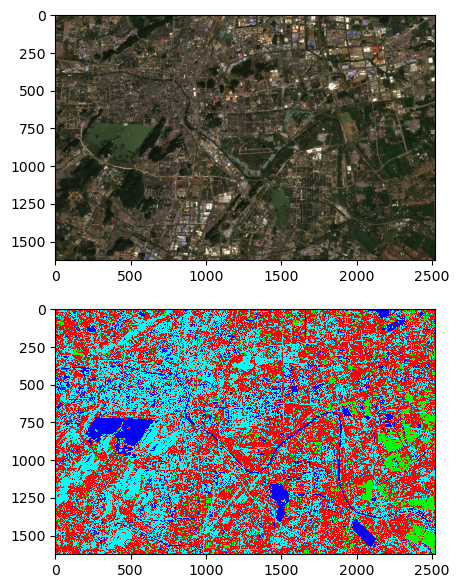

In [66]:
fig, axs = plt.subplots(2,1,figsize=(10,7))

img_stretched = color_stretch(reshaped_img, [2, 1, 0])
axs[0].imshow(img_stretched*5)

axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')

# fig.show()